In [0]:
# 0. 사용할 패키지 불러오기
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

# sliding window 를 하나의 데이터 포인트씩 밀면서 한 줄의 벡터로 구성
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

shape of x train: (760, 40, 1)
shape of x val  : (360, 40, 1)
shape of x test : (360, 40, 1)


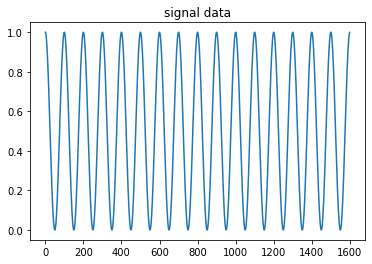

In [2]:
# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

plt.figure()
plt.plot(signal_data)
plt.title("signal data")

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
look_back = 40

x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(f"shape of x train: {x_train.shape}")
print(f"shape of x val  : {x_val.shape}")
print(f"shape of x test : {x_test.shape}")

In [3]:
# 2. 모델 구성하기
model = tf.keras.Sequential([
    LSTM(units=32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True),
    Dropout(0.5),
    LSTM(units=32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True),
    Dropout(0.5),
    LSTM(units=32, batch_input_shape=(1, look_back, 1), stateful=True),
    Dropout(0.5),
    Dense(1)
])

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 40, 32)               4352      
_________________________________________________________________
dropout (Dropout)            (1, 40, 32)               0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 40, 32)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (1, 40, 32)               0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 32)                   8320      
_________________________________________________________________
dropout_2 (Dropout)          (1, 32)                   0         
_________________________________________________________________
dense (Dense)                (1, 1)                    3

In [4]:
# 조기 종료
earlystopping_callback = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4, patience=5)

# 체크포인트가 저장될 디렉토리
checkpoint_dir = './training_checkpoints_LSTM'

# 체크포인트 파일 이름
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True)

my_callbacks = [
    earlystopping_callback,
    checkpoint_callback
]

# 4. 모델 학습시키기
history = model.fit(x_train, y_train, epochs=50, 
                    batch_size=1, shuffle=False, 
                    callbacks=[my_callbacks], 
                    validation_data=(x_val, y_val))

Epoch 1/50
760/760 [==============================] - 28s 37ms/step - loss: 0.0585 - accuracy: 0.0197 - val_loss: 0.0632 - val_accuracy: 0.0194
Epoch 2/50
760/760 [==============================] - 27s 36ms/step - loss: 0.0231 - accuracy: 0.0197 - val_loss: 0.0148 - val_accuracy: 0.0194
Epoch 3/50
760/760 [==============================] - 27s 36ms/step - loss: 0.0151 - accuracy: 0.0197 - val_loss: 0.0309 - val_accuracy: 0.0194
Epoch 4/50
760/760 [==============================] - 27s 36ms/step - loss: 0.0121 - accuracy: 0.0197 - val_loss: 0.0024 - val_accuracy: 0.0194
Epoch 5/50
760/760 [==============================] - 27s 36ms/step - loss: 0.0111 - accuracy: 0.0197 - val_loss: 0.0045 - val_accuracy: 0.0194
Epoch 6/50
760/760 [==============================] - 27s 36ms/step - loss: 0.0085 - accuracy: 0.0197 - val_loss: 0.0026 - val_accuracy: 0.0194
Epoch 7/50
760/760 [==============================] - 27s 36ms/step - loss: 0.0078 - accuracy: 0.0197 - val_loss: 0.0013 - val_accuracy:

In [5]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

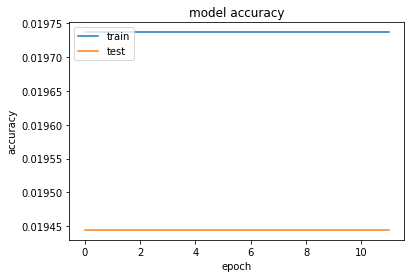

In [6]:
# 5. 학습과정 살펴보기
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'./training_checkpoints_LSTM/ckpt_7'

In [8]:
model.load_weights(latest)

# 6. 모델 평가하기
train_score = model.evaluate(x_train, y_train, batch_size=1, verbose=0)

print(f'Train Score: {round(train_score[1], 2)}')
val_score = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
print(f'Validataion Score: {round(val_score[1], 2)}')
test_score = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print(f'Test Score: {round(test_score[1], 2)}')

Train Score: 0.02
Validataion Score: 0.02
Test Score: 0.02


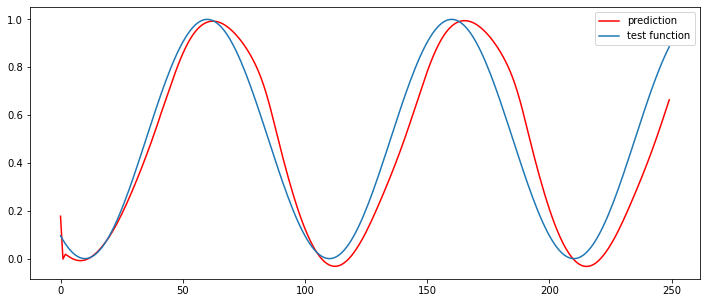

In [9]:
# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()